# RIPE Simulations

The purpose of this notebook is to evaluate and help understand RIPE's behavior with respect to its various parameters.

## Package Imports

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import RIPE

plt.rcParams['figure.figsize'] = 10, 8

#### Simulations parameters

In [5]:
nRows = 5000
nCols = 2 # In this notebook, Y depends only on X1 and X2.
# If nCols > 2 you add irrelevant columns to add noise (also interesting)
noise = 1
X = np.random.uniform(low=-1, high=1,
                      size=(nRows, nCols))

#### Plot parameters

In [6]:
h = 0.01
cm = plt.cm.coolwarm # plt.cm.binary

#### RIPE parameters

In [ ]:
nbbucket = 10 # Number of Bins for the discretization
intermax = 1.0 - np.finfo(float).eps # Maximal intersection rate between two rules during the selection
signicrit = 'variance' # The choose of the z function

## Data generator

We will generate three datasets. Each dataset is divisible into  three areas. A positive one, where $ y \sim N (2, \sigma) $, a negative one, where $ y \sim N (-2,\sigma) $ and finally a zero one, where $ y \sim N (0, \sigma) $. The positive and negative areas are such that $ E [y] = 0 $.

In [ ]:
def make_y(x, sigma, th_min=-0.4, th_max=0.4):
    y = [np.random.normal(-2, sigma) if x_val <= th_min else
         np.random.normal(0, sigma) if x_val <= th_max else
         np.random.normal(2, sigma) for x_val in x]
    return np.array(y)

### Linear Dataset

In [70]:
x_vect = X[:, 0]
th_min = -0.4
th_max = 0.4

y = make_y(x_vect, noise, th_min, th_max)

In [71]:
test_size = 0.40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=42)

In [73]:
ripe_lin = RIPE.Learning(signicrit=signicrit,
                         intermax=intermax)

In [74]:
%%time
ripe_lin.fit(X_train, y_train)

Design for complexity 2
----- Selection ------
CPU times: user 2min 16s, sys: 3.55 s, total: 2min 19s
Wall time: 2min 20s


### Evolution of the criterium during the selection

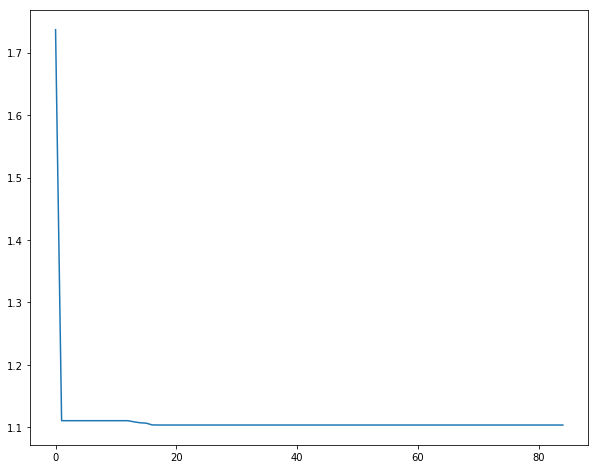

In [75]:
plt.plot(ripe_lin.critlist)

### Plot of the true model vs the model inferred by RIPE

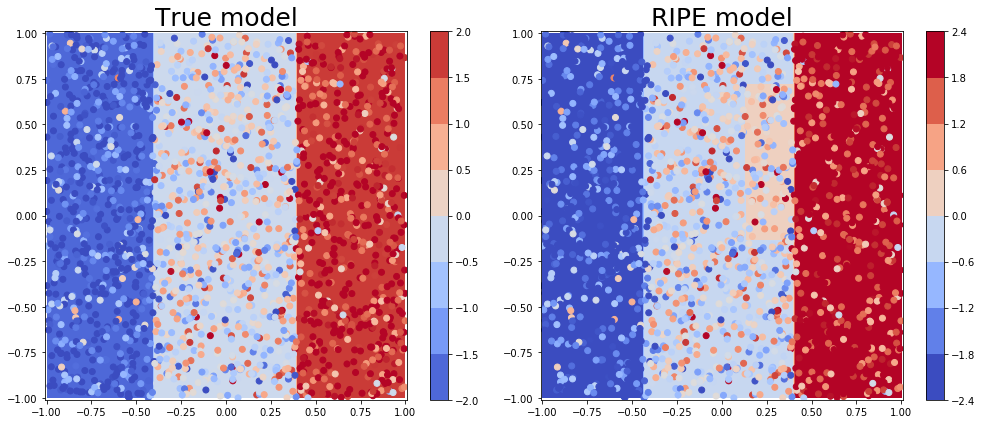

In [76]:
figure = plt.figure(figsize=(14, 6))

x_min, x_max = X[:, 0].min(), X[:, 0].max() + h # add left and right marges
y_min, y_max = X[:, 1].min(), X[:, 1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

ax = plt.subplot(1, 2, 1)

plt.title("True model", fontsize=25)

Z = make_y(xx.ravel(), 0, th_min, th_max)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, vmax=2, vmin=-2)
scatter_plt = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, vmax=2, vmin=-2)
plt.axis([-1-0.01, 1+0.01, -1-0.01, 1+0.01])
plt.colorbar()

ax = plt.subplot(1, 2, 2)
plt.title("RIPE model", fontsize=25)
ZZ = ripe_lin.predict(np.matrix(zip(xx.ravel(), yy.ravel())), check_input=False)
ZZ = ZZ.reshape(xx.shape)
plt.contourf(xx, yy, ZZ, cmap=cm, vmax=2, vmin=-2)
scatter_plt = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, vmax=2, vmin=-2)
plt.axis([-1-0.01, 1+0.01, -1-0.01, 1+0.01])
plt.colorbar()
figure.tight_layout()

# plt.savefig('/Users/Vmargot/Dropbox/AdLearn_Simulation/Graph_lin1.png', format='png', dpi=440)

In [77]:
print 'Test Score :', ripe_lin.score(X_test, y_test)
print 'Train Score :', ripe_lin.score(X_train, y_train)

Test Score : 0.688670791313
Train Score : 0.668307209817


### Plot of the conditions of the selected rules according to X1 and X2

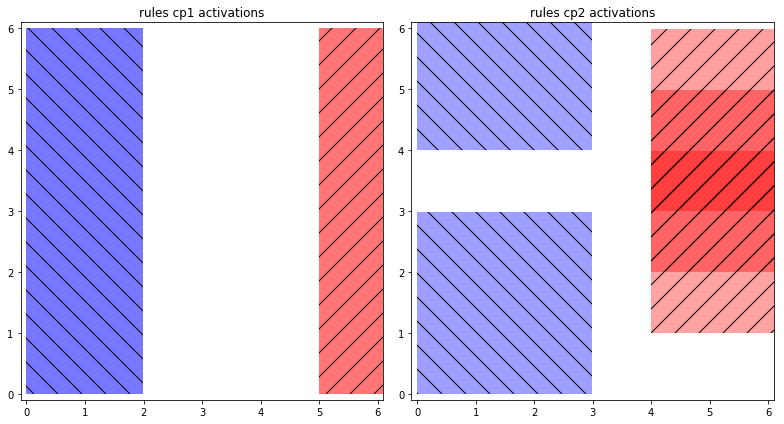

In [78]:
figure = plt.figure(figsize=(11, 6))

ax = plt.subplot(1, 2, 1)
ripe_lin.plot_rules(0,1, cp=1)#, col_pos='black', col_neg='whitesmoke')

ax = plt.subplot(1, 2, 2)
ripe_lin.plot_rules(0, 1, cp=2)#, col_pos='black', col_neg='whitesmoke')

figure.tight_layout()

### DataFrame of the selected RuleSet

In [79]:
df = ripe_lin.make_selected_df()
df

,Conditions,Coverage,Prediction,Z,Criterion
R 0(1)+,"X0 $\in$ [5.0, 6.0]",0.29,1.09,0.83,1.74
R 1(1)-,"X0 $\in$ [0.0, 1.0]",0.29,-1.07,0.83,1.81
R 2(2)+,"X0 $\in$ [4.0, 6.0] & X1 $\in$ [3.0, 5.0]",0.19,0.75,0.69,2.89
R 3(2)-,"X0 $\in$ [0.0, 2.0] & X1 $\in$ [0.0, 2.0]",0.18,-0.76,0.63,2.89
R 4(2)+,"X0 $\in$ [4.0, 6.0] & X1 $\in$ [2.0, 4.0]",0.19,0.75,0.66,2.90
R 5(2)-,"X0 $\in$ [0.0, 2.0] & X1 $\in$ [4.0, 6.0]",0.19,-0.74,0.65,2.90
R 6(2)+,"X0 $\in$ [4.0, 6.0] & X1 $\in$ [1.0, 3.0]",0.19,0.73,0.66,2.92
R 7,No rule activated,0.20,0.00,0.82,3.33


### DataFrame of the full RuleSet

Here we have the Dataframe of all acceptable rule designed by RIPE.

In [20]:
ripe_lin.ruleset.to_df()

,Features_Name,BMin,BMax,Cov,Pred,Crit,Th
R 0(1)-,[X0],[0.0],[2.0],0.300000,-1.077586,1.662946,0.552774
R 1(1)+,[X0],[7.0],[9.0],0.300000,1.070695,1.683950,0.574906
R 2(1)-,[X0],[0.0],[3.0],0.400000,-0.820368,1.825101,0.709710
R 3(1)+,[X0],[6.0],[9.0],0.400000,0.811065,1.858595,0.723688
R 4(1)+,[X0],[8.0],[9.0],0.200000,1.114463,2.282468,0.529031
R 5(1)-,[X0],[0.0],[1.0],0.200000,-1.095372,2.317381,0.552171
R 6(1)-,[X0],[1.0],[2.0],0.200000,-1.060927,2.378850,0.535119
R 7(1)+,[X0],[7.0],[8.0],0.200000,1.050133,2.397707,0.591895
R 8(1)-,[X0],[1.0],[3.0],0.300000,-0.723523,2.567675,0.721087
R 9(1)+,[X0],[6.0],[8.0],0.300000,0.710815,2.593535,0.749657


### An other linear Dataset

In [80]:
x_vect = X[:, 0] + X[:, 1]
th_min = -0.4
th_max = 0.4

y = make_y(x_vect, noise, th_min, th_max)

In [81]:
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=42)

In [84]:
ripe_lin2 = RIPE.Learning(signicrit=signicrit,
                          intermax=intermax)

In [85]:
%%time
ripe_lin2.fit(X_train, y_train)

Design for complexity 2
----- Selection ------
CPU times: user 3min 54s, sys: 11.9 s, total: 4min 6s
Wall time: 4min 6s


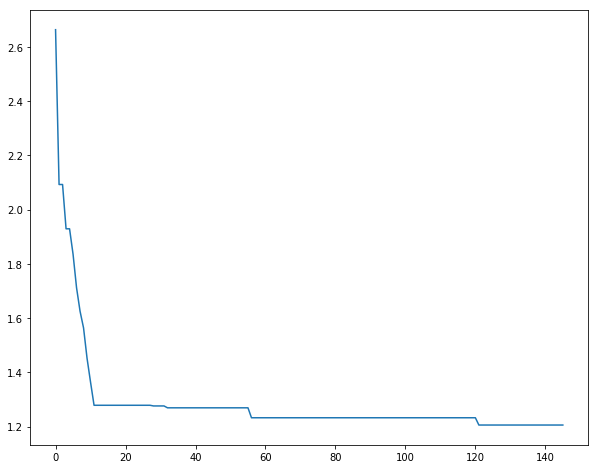

In [86]:
plt.plot(ripe_lin2.critlist)

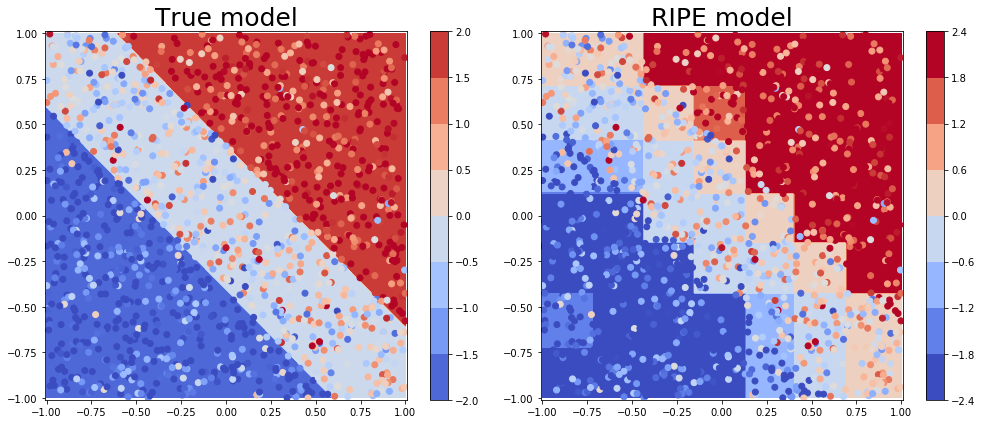

In [87]:
figure = plt.figure(figsize=(14, 6))

x_min, x_max = X[:, 0].min(), X[:, 0].max() + h # add left and right marges
y_min, y_max = X[:, 1].min(), X[:, 1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

ax = plt.subplot(1, 2, 1)

plt.title("True model", fontsize=25)

Z = make_y(xx.ravel() + yy.ravel(), 0, th_min, th_max)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, vmax=2, vmin=-2)  
scatter_plt = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, vmax=2, vmin=-2)
plt.axis([-1-0.01, 1+0.01, -1-0.01, 1+0.01])
plt.colorbar()

ax = plt.subplot(1, 2, 2)
plt.title("RIPE model", fontsize=25)
ZZ = ripe_lin2.predict(np.matrix(zip(xx.ravel(), yy.ravel())), check_input=False)
ZZ = ZZ.reshape(xx.shape)
plt.contourf(xx, yy, ZZ, cmap=cm, vmax=2, vmin=-2)  
scatter_plt = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, vmax=2, vmin=-2)
plt.axis([-1-0.01, 1+0.01, -1-0.01, 1+0.01])
plt.colorbar()
figure.tight_layout()

# plt.savefig('/Users/Vmargot/Dropbox/AdLearn Lab/LinRez.png', format='png', dpi=440)
# plt.savefig('/media/adcalcul3/D/Dropbox/AdLearn Lab/LinRez.png', format='png', dpi=250)

In [88]:
print 'Test Score :', ripe_lin2.score(X_test, y_test)
print 'Train Score :', ripe_lin2.score(X_train, y_train)

Test Score : 0.635464795134
Train Score : 0.662223864269


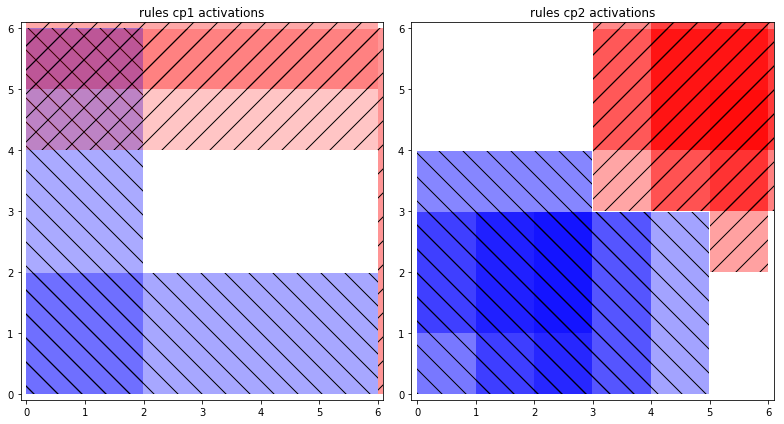

In [89]:
figure = plt.figure(figsize=(11, 6))

ax = plt.subplot(1, 2, 1)
ripe_lin2.plot_rules(0,1, cp=1)#, col_pos='black', col_neg='whitesmoke')

ax = plt.subplot(1, 2, 2)
ripe_lin2.plot_rules(0,1, cp=2)#, col_pos='black', col_neg='whitesmoke')

figure.tight_layout()

In [90]:
df = ripe_lin2.make_selected_df()
df

,Conditions,Coverage,Prediction,Z,Criterion
R 0(2)+,"X0 $\in$ [4.0, 6.0] & X1 $\in$ [4.0, 6.0]",0.18,1.07,0.85,2.66
R 1(2)-,"X1 $\in$ [0.0, 2.0] & X0 $\in$ [0.0, 2.0]",0.18,-1.06,0.86,2.67
R 2(2)+,"X0 $\in$ [4.0, 6.0] & X1 $\in$ [3.0, 5.0]",0.19,1.00,0.77,2.75
R 3(2)-,"X1 $\in$ [0.0, 2.0] & X0 $\in$ [1.0, 3.0]",0.19,-0.95,0.80,2.83
R 4(2)-,"X0 $\in$ [0.0, 2.0] & X1 $\in$ [1.0, 3.0]",0.18,-0.95,0.80,2.87
R 5(2)+,"X1 $\in$ [4.0, 6.0] & X0 $\in$ [3.0, 5.0]",0.18,0.93,0.76,2.88
R 6(1)-,"X1 $\in$ [0.0, 1.0]",0.29,-0.69,0.68,2.89
R 7(1)+,X0 = 6.0,0.14,0.83,0.68,3.16
R 8(1)+,"X1 $\in$ [5.0, 6.0]",0.29,0.68,0.65,2.91
R 9(1)-,"X0 $\in$ [0.0, 1.0]",0.29,-0.67,0.65,2.93


In [91]:
ripe_lin2.ruleset.to_df()

,Features_Name,BMin,BMax,Cov,Pred,Crit,Th
R 0(2)+,"[X0, X1]","[4.0, 4.0]","[6.0, 6.0]",0.181714,1.068909,2.663559,0.849896
R 1(2)-,"[X1, X0]","[0.0, 0.0]","[2.0, 2.0]",0.183714,-1.059098,2.668121,0.862144
R 2(1)-,[X1],[0.0],[2.0],0.428571,-0.567621,2.706678,0.578163
R 3(1)+,[X0],[4.0],[6.0],0.428571,0.558157,2.735198,0.525779
R 4(2)+,"[X0, X1]","[4.0, 3.0]","[6.0, 5.0]",0.187429,0.999992,2.745897,0.774117
R 5(1)+,[X1],[4.0],[6.0],0.428571,0.550708,2.757310,0.537478
R 6(1)-,[X0],[0.0],[2.0],0.428571,-0.549286,2.761496,0.553459
R 7(2)-,"[X1, X0]","[0.0, 1.0]","[2.0, 3.0]",0.185143,-0.954716,2.829986,0.796642
R 8(2)-,"[X0, X1]","[0.0, 1.0]","[2.0, 3.0]",0.179714,-0.947160,2.867644,0.801965
R 9(2)+,"[X1, X0]","[4.0, 3.0]","[6.0, 5.0]",0.182857,0.925976,2.884324,0.758034


### No linear Dataset

In [92]:
np.random.seed(42)

In [93]:
x_vect = np.square(X[:, 0]) + np.square(X[:, 1])
th_min = 0.5
th_max = 0.8

y = make_y(x_vect, noise, th_min, th_max)

In [94]:
test_size = 0.40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=42)

In [97]:
ripe_nolin = RIPE.Learning(signicrit=signicrit,
                           intermax=intermax)

In [98]:
%%time
ripe_nolin.fit(X_train, y_train)

Design for complexity 2
----- Selection ------
CPU times: user 5min 22s, sys: 16.8 s, total: 5min 38s
Wall time: 5min 39s


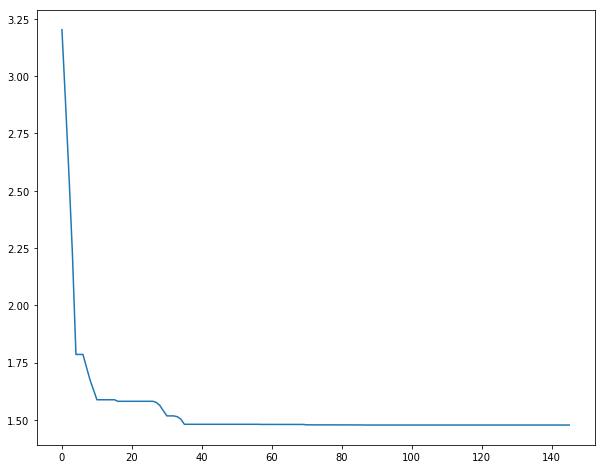

In [99]:
plt.plot(ripe_nolin.critlist)

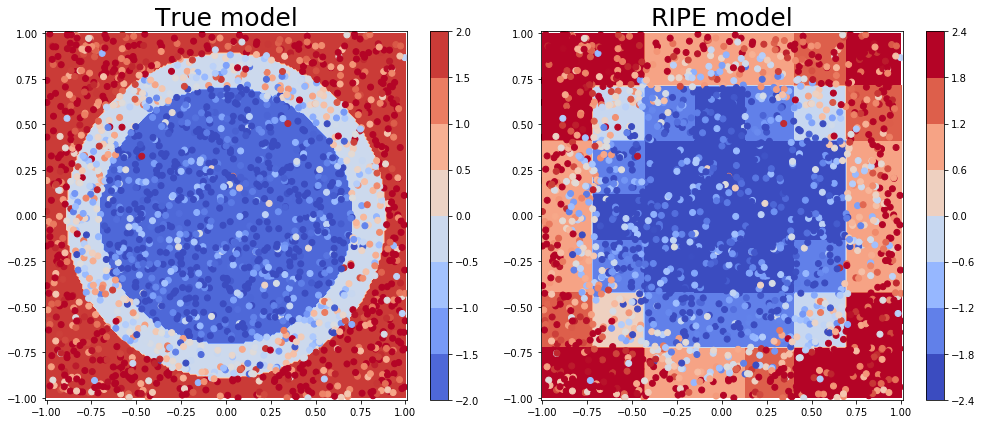

In [100]:
figure = plt.figure(figsize=(14, 6))

x_min, x_max = X[:, 0].min(), X[:, 0].max() + h # add left and right marges
y_min, y_max = X[:, 1].min(), X[:, 1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

ax = plt.subplot(1, 2, 1)

plt.title("True model", fontsize=25)

Z = make_y(np.square(xx.ravel()) + np.square(yy.ravel()), 0, th_min, th_max)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, vmax=2, vmin=-2)  
scatter_plt = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, vmax=2, vmin=-2)
plt.axis([-1-0.01, 1+0.01, -1-0.01, 1+0.01])
plt.colorbar()

ax = plt.subplot(1, 2, 2)
plt.title("RIPE model", fontsize=25)
ZZ = ripe_nolin.predict(np.matrix(zip(xx.ravel(), yy.ravel())), check_input=False)
ZZ = ZZ.reshape(xx.shape)
plt.contourf(xx, yy, ZZ, cmap=cm, vmax=2, vmin=-2)
scatter_plt = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, vmax=2, vmin=-2)
plt.axis([-1-0.01, 1+0.01, -1-0.01, 1+0.01])
plt.colorbar()
figure.tight_layout()

#plt.savefig('/Users/Vmargot/Dropbox/NoLinRez.png', format='png', dpi=80, bbox_inches='tight')

In [101]:
print 'Test Score :', ripe_nolin.score(X_test, y_test)
print 'Train Score :', ripe_nolin.score(X_train, y_train)

Test Score : 0.627197912305
Train Score : 0.633099334218


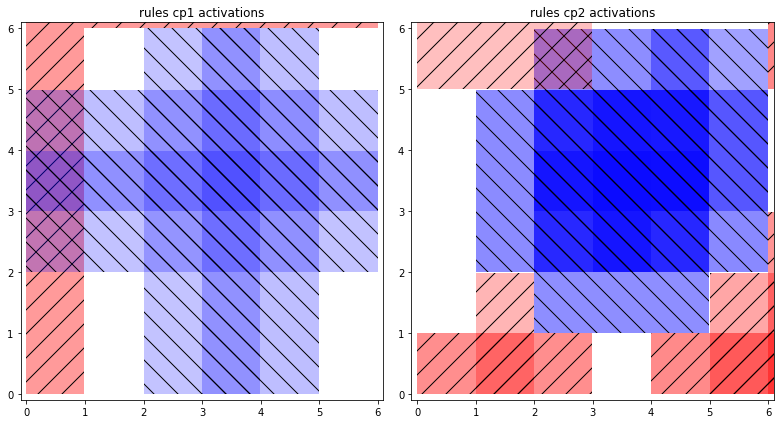

In [102]:
figure = plt.figure(figsize=(11, 6))

ax = plt.subplot(1, 2, 1)
ripe_nolin.plot_rules(0, 1, cp=1)#, col_pos='black', col_neg='whitesmoke')

ax = plt.subplot(1, 2, 2)
ripe_nolin.plot_rules(0, 1, cp=2)#, col_pos='black', col_neg='whitesmoke')

figure.tight_layout()
# plt.savefig('/Users/Vmargot/Dropbox/NoLinRezRules.png', format='png', dpi=80, bbox_inches='tight')

In [103]:
df = ripe_nolin.make_selected_df()
df

,Conditions,Coverage,Prediction,Z,Criterion
R 0(2)-,"X1 $\in$ [2.0, 4.0] & X0 $\in$ [2.0, 4.0]",0.18,-0.96,0.86,3.20
R 1(2)-,"X1 $\in$ [2.0, 4.0] & X0 $\in$ [3.0, 5.0]",0.19,-0.92,0.83,3.24
R 2(2)-,"X0 $\in$ [2.0, 4.0] & X1 $\in$ [3.0, 5.0]",0.19,-0.89,0.83,3.30
R 3(2)-,"X1 $\in$ [2.0, 4.0] & X0 $\in$ [1.0, 3.0]",0.18,-0.91,0.84,3.30
R 4(2)-,"X0 $\in$ [2.0, 4.0] & X1 $\in$ [1.0, 3.0]",0.18,-0.88,0.83,3.32
R 5(2)-,"X1 $\in$ [3.0, 5.0] & X0 $\in$ [4.0, 5.0]",0.12,-0.74,0.73,3.71
R 6(2)+,"X1 $\in$ [0.0, 1.0] & X0 $\in$ [5.0, 6.0]",0.08,0.70,0.70,3.85
R 7(2)+,"X1 $\in$ [5.0, 6.0] & X0 $\in$ [0.0, 2.0]",0.13,0.50,0.47,3.88
R 8(2)+,"X1 $\in$ [0.0, 1.0] & X0 = 1.0",0.04,0.58,0.57,3.97
R 9(1)-,"X0 $\in$ [3.0, 4.0]",0.29,-0.51,0.46,3.62


In [ ]:
ripe_nolin.ruleset.to_df()